In [1]:
import xarray as xr
from eofs.xarray import Eof
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt

In [2]:
# Open HadISST 
sst_ds = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc')
sst = sst_ds.sst.sel(lat=slice(-30,30)).sel(lon=slice(120,270)).sel(time=slice('1900-01', '2014-12'))

In [3]:
# Detrend 
sst_detrend = np.apply_along_axis(func.detrend_2step, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)

In [4]:
clim = sst_dt.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = sst_dt.groupby('time.month') - clim

In [5]:
eof, pcs, var = func.eof_and_pcs(anom, 2)

Text(0, 0.5, 'Latitude [degrees_north]')

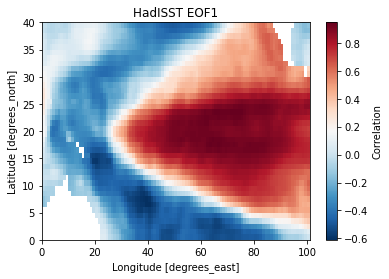

In [6]:
plt.pcolormesh(eof.sel(mode=0)*(-1), cmap='RdBu_r')
plt.colorbar(label='Correlation')
plt.title('HadISST EOF1')
plt.xlabel('Longitude [degrees_east]')
plt.ylabel('Latitude [degrees_north]')
#plt.savefig('HadISST_EOF1.jpg', bbox_inches='tight', dpi=300)

Text(0, 0.5, 'Latitude [degrees_north]')

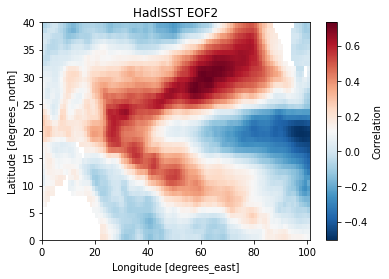

In [7]:
plt.pcolormesh(eof.sel(mode=1), cmap='RdBu_r')
plt.colorbar(label='Correlation')
plt.title('HadISST EOF2')
plt.xlabel('Longitude [degrees_east]')
plt.ylabel('Latitude [degrees_north]')
#plt.savefig('HadISST_EOF2.jpg', bbox_inches='tight', dpi=300)

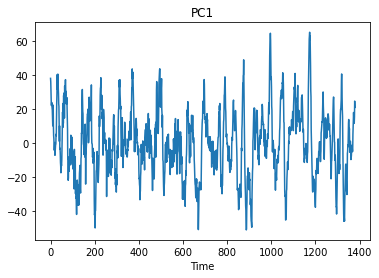

In [40]:
plt.plot(pcs.sel(mode=1)*(-1))
plt.xlabel('Time')
plt.title('PC1')
#plt.savefig('HadISST_PC1.jpg', bbox_inches='tight', dpi=300)

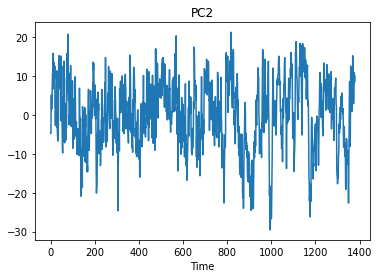

In [41]:
plt.plot(pcs.sel(mode=2))
plt.xlabel('Time')
plt.title('PC2')
#plt.savefig('HadISST_PC2.jpg', bbox_inches='tight', dpi=300)

In [42]:
var

<xarray.DataArray 'variance_fractions' (mode: 2)>
array([0.43062505, 0.08526166], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1
Attributes:
    long_name:  variance_fractions

In [ ]:
E = (eof.sel(mode=0) - eof.sel(mode=1))/np.sqrt(2)
C = (eof.sel(mode=0) + eof.sel(mode=1))/np.sqrt(2)

In [ ]:
E.plot()

In [ ]:
C.plot()

In [ ]:
E_index = (pcs.sel(mode=1) - pcs.sel(mode=2))/np.sqrt(2)
C_index = (pcs.sel(mode=1) + pcs.sel(mode=2))/np.sqrt(2)

In [ ]:
E_index.plot()

In [ ]:
C_index.plot()

### Now with CMIP6 models 

In [8]:
# Read in models 
multi_model = func.read_in_cmip_models('/g/data/eg3/mf3225/CMIP_TS/CMIP6/historical', 'r1i1p1f1', 'ts', '1850-01', '2015-01')
# Order models alphabetically 
multi_model = multi_model.sortby('model')
# Select out surface temperature data 
data = multi_model.ts

Model FGOALS-g3 has weird time


In [ ]:
# Detrend temp data
data_dt = xr.apply_ufunc(func.detrend_2step, data, 
                             input_core_dims=[['time']],
                             output_core_dims=[['time']],
                             vectorize=True,
                             dask='parallelized')

data_dt = data_dt.transpose(*data.dims).chunk('auto').sel(time=slice('1900-01', '2014-12'))

In [ ]:
sst_region = data_dt.sel(lat=slice(-30,30)).sel(lon=slice(120,270))

In [ ]:
clims = sst_region.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anoms = sst_region.groupby('time.month') - clims

In [ ]:
eofs_list = []
pcs_list = []
var_list = []
for m in anoms.model:
    e, p, v = func.eof_and_pcs(anoms.sel(model=m).chunk({'time':-1, 'lat':-1, 'lon':-1}), 3)
    eofs_list.append(e)
    pcs_list.append(p)
    var_list.append(v)

In [ ]:
model_eofs = xr.concat(eofs_list, dim='model').chunk('auto')
model_pcs = xr.concat(pcs_list, dim='model').chunk('auto')
model_var = xr.concat(var_list, dim='model').chunk('auto')

In [ ]:
model_names = data.model.values
model_eofs = model_eofs.assign_coords(model = model_names)
model_pcs = model_pcs.assign_coords(model = model_names)
model_var = model_var.assign_coords(model = model_names)

In [ ]:
#model_eofs.to_netcdf('/g/data/w40/rl5183/model_eofs.nc')
#model_pcs.to_netcdf('/g/data/w40/rl5183/model_pcs.nc')
#model_var.to_netcdf('/g/data/w40/rl5183/model_var.nc')

In [9]:
model_eofs = xr.open_dataarray('/g/data/w40/rl5183/model_eofs.nc')
model_pcs = xr.open_dataarray('/g/data/w40/rl5183/model_pcs.nc')
model_var = xr.open_dataarray('/g/data/w40/rl5183/model_var.nc')

In [10]:
def pattern_corr(model_pattern, ob_pattern):
    # Flatten
    d1 = model_pattern.values.flatten()
    # Apply mask to get rid of NaN
    d1 = d1[np.isfinite(ob_pattern)]
    ob_pattern = ob_pattern[np.isfinite(ob_pattern)]
    # Calculate correlation
    from scipy.stats import pearsonr
    corr = pearsonr(ob_pattern, d1)
    #print(f'model {m} works')
    return corr[0]

In [11]:
# Flatten obs eofs
ob_eof_1_1d = (eof.sel(mode=0)*(-1)).values.flatten()
ob_eof_2_1d = eof.sel(mode=1).values.flatten()

In [12]:
EOF1_pattern_corr = []
for m in model_eofs.model:
    EOF1_pattern_corr.append(pattern_corr(model_eofs.sel(mode=0).sel(model=m), ob_eof_1_1d))

In [13]:
EOF2_pattern_corr = []
for m in model_eofs.model:
    EOF2_pattern_corr.append(pattern_corr(model_eofs.sel(mode=1).sel(model=m), ob_eof_2_1d))

In [14]:
EOF2_3_pattern_corr = []
for m in model_eofs.model:
    EOF2_3_pattern_corr.append(pattern_corr(model_eofs.sel(mode=2).sel(model=m), ob_eof_2_1d))

In [15]:
model_names = data.model.values
names = list(model_names)

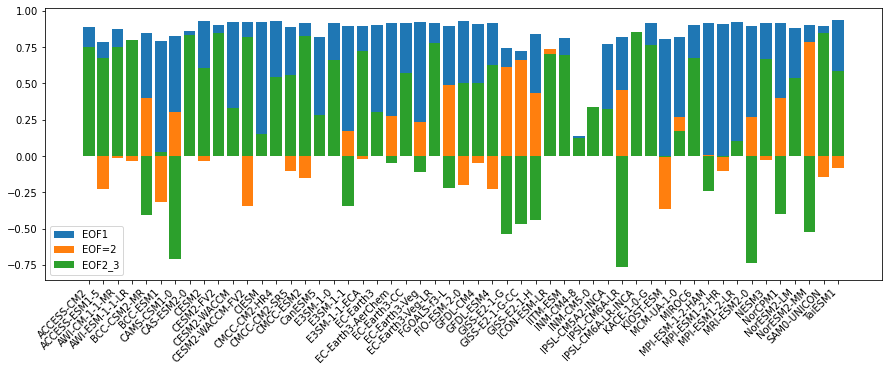

In [16]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.bar(names, EOF1_pattern_corr, label='EOF1')
ax.bar(names, EOF2_pattern_corr, label='EOF=2')
ax.bar(names, EOF2_3_pattern_corr, label='EOF2_3')
plt.xticks(rotation=45, ha='right')
plt.legend()
#plt.savefig('HadISST_CMIP6_EOF_pattern_corr.jpg', bbox_inches='tight', dpi=300)

In [17]:
data = []
for i in np.arange(0,len(names)):
    cell = [names[i], EOF1_pattern_corr[i], EOF2_pattern_corr[i], EOF2_3_pattern_corr[i]]
    data.append(cell)

In [18]:
df = pd.DataFrame(data, columns=['Model', 'EOF1', 'EOF2', 'EOF2_3'])
df.head()

,Model,EOF1,EOF2,EOF2_3
0,ACCESS-CM2,0.886077,0.298282,0.750259
1,ACCESS-ESM1-5,0.782859,-0.228854,0.674353
2,AWI-CM-1-1-MR,0.871441,-0.012316,0.750875
3,AWI-ESM-1-1-LR,0.752165,-0.033581,0.800030
4,BCC-CSM2-MR,0.847905,0.400240,-0.406581


<AxesSubplot:xlabel='Model'>

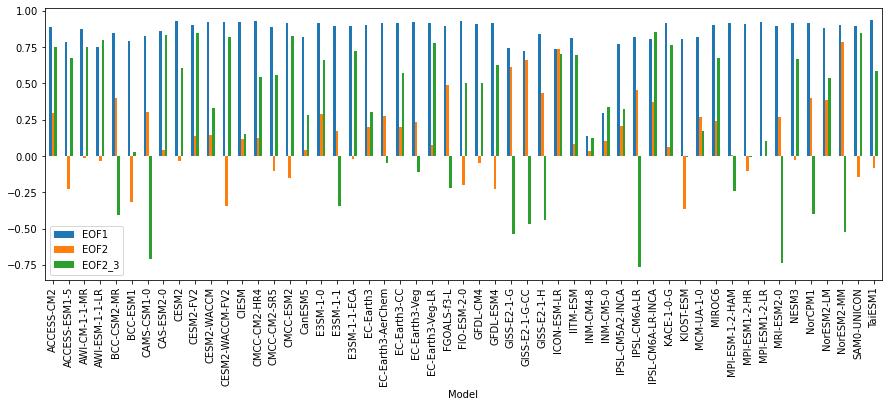

In [19]:
df.plot(x='Model', kind='bar', stacked=False, figsize=(15,5))
#plt.savefig('HadISST_CMIP6_EOF_pattern_corr_v2', bbox_inches='tight', dpi=300)

Text(0, 0.5, 'EOF2 pattern corr')

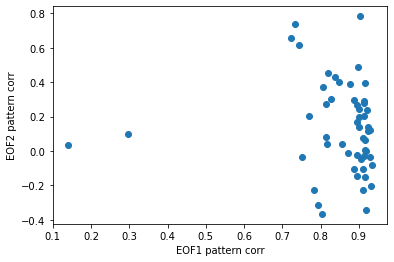

In [20]:
plt.scatter(EOF1_pattern_corr, EOF2_pattern_corr)
plt.xlabel('EOF1 pattern corr')
plt.ylabel('EOF2 pattern corr')
#plt.savefig('HadISST_CMIP6_EOF_pattern_corr_scatter', bbox_inches='tight', dpi=300)

Text(0, 0.5, 'EOF2_3 pattern corr')

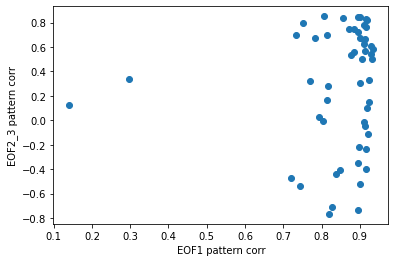

In [21]:
plt.scatter(EOF1_pattern_corr, EOF2_3_pattern_corr)
plt.xlabel('EOF1 pattern corr')
plt.ylabel('EOF2_3 pattern corr')
#plt.savefig('HadISST_CMIP6_EOF_pattern_corr_scatter_v2', bbox_inches='tight', dpi=300)

In [25]:
# Take absolute values 
EOF1_pattern_corr_abs = np.absolute(EOF1_pattern_corr)
EOF2_pattern_corr_abs = np.absolute(EOF2_pattern_corr)
EOF2_3_pattern_corr_abs = np.absolute(EOF2_3_pattern_corr)
# Put in new dataframe 
abs_data = []
for i in np.arange(0,len(names)):
    cell = [names[i], EOF1_pattern_corr_abs[i], EOF2_pattern_corr_abs[i], EOF2_3_pattern_corr_abs[i]]
    abs_data.append(cell)
abs_df = pd.DataFrame(abs_data, columns=['Model', 'EOF1', 'EOF2', 'EOF2_3'])

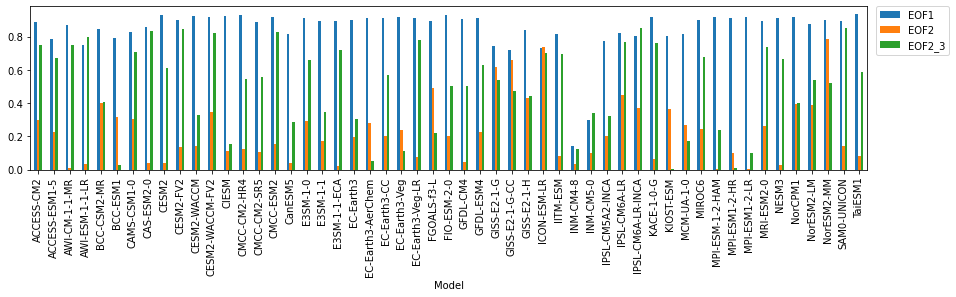

In [38]:
abs_df.plot(x='Model', kind='bar', stacked=False, figsize=(15,3))
plt.legend(loc=(1.01,0.7))
#plt.savefig('HadISST_CMIP6_EOF_pattern_corr_abs', bbox_inches='tight', dpi=300)

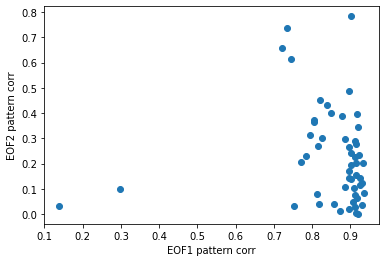

In [41]:
plt.scatter(EOF1_pattern_corr_abs, EOF2_pattern_corr_abs)
plt.xlabel('EOF1 pattern corr')
plt.ylabel('EOF2 pattern corr')
#plt.savefig('HadISST_CMIP6_EOF_pattern_corr_scatter_abs', bbox_inches='tight', dpi=300)

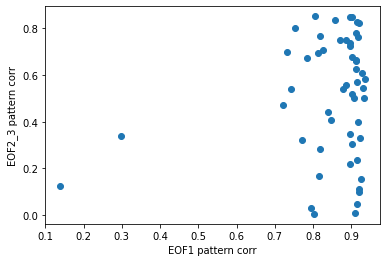

In [43]:
plt.scatter(EOF1_pattern_corr_abs, EOF2_3_pattern_corr_abs)
plt.xlabel('EOF1 pattern corr')
plt.ylabel('EOF2_3 pattern corr')
#plt.savefig('HadISST_CMIP6_EOF_pattern_corr_scatter_abs_v2', bbox_inches='tight', dpi=300)